In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

df = pd.read_csv('data/pomiar_bez_20.csv')
t = df['czas [s]'].to_numpy()
dt = np.diff(t)
fs = 1.0 / np.median(dt)
print(f"[INFO] fs z pliku ≈ {fs:.2f} Hz")

lsb_to_g = 0.0039
x = df['X'].to_numpy(dtype=float) * lsb_to_g

N0 = int(min(len(x), max(1, int(2*fs))))       # do 2 s na estymację offsetu
x0 = x - np.mean(x[:N0]) if N0>0 else x
b, a = signal.butter(2, 5/(fs/2), btype='highpass')  # fc=5 Hz
x_hp = signal.filtfilt(b, a, x0)

[INFO] fs z pliku ≈ 1600.00 Hz


[INFO] Top piki (Hz, amplituda[g]):
    630.83 Hz   0.465 g
     68.56 Hz   0.305 g
    378.85 Hz   0.257 g
    556.27 Hz   0.242 g
     69.74 Hz   0.198 g
    631.31 Hz   0.198 g
[INFO] Szacunek obrotów z FFT: f≈68.56 Hz  (~4114 RPM)


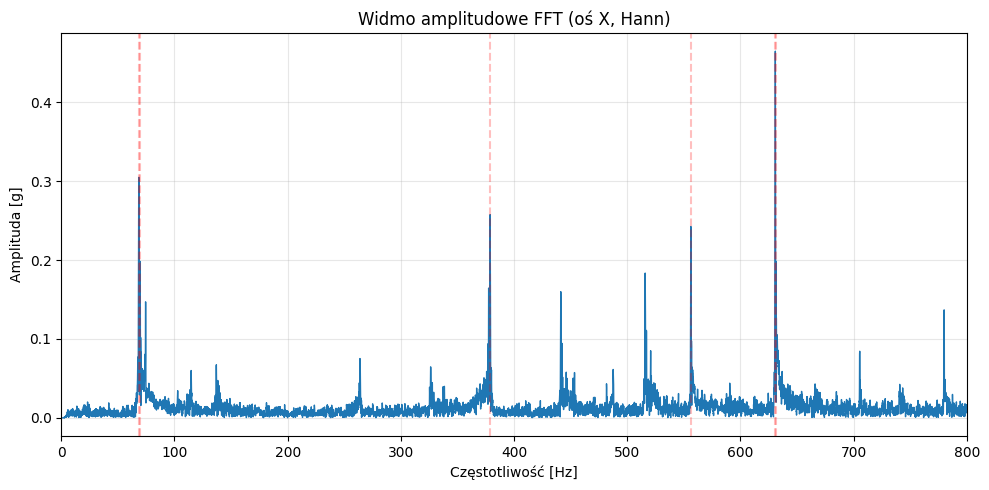

In [6]:
N = len(x_hp)
win = signal.windows.hann(N, sym=False)
Xf = np.fft.rfft(x_hp * win)                   # tylko część dodatnia
freqs = np.fft.rfftfreq(N, d=1/fs)
amp = (2.0 / np.sum(win)) * np.abs(Xf)

fmin, fmax = 20, 800
m = (freqs >= fmin) & (freqs <= fmax)
peaks, props = signal.find_peaks(amp[m], prominence=np.median(amp[m])*8)

f_peaks = freqs[m][peaks]
a_peaks = amp[m][peaks]
idx_sorted = np.argsort(a_peaks)[::-1]
f_top = f_peaks[idx_sorted][:6]
a_top = a_peaks[idx_sorted][:6]
print("[INFO] Top piki (Hz, amplituda[g]):")
for f0, a0 in zip(f_top, a_top):
    print(f"  {f0:8.2f} Hz   {a0:.3f} g")

# „RPM z FFT” – weź najsilniejszy pik w paśmie np. 40..120 Hz
band_rot = (40, 120)
mm = (freqs >= band_rot[0]) & (freqs <= band_rot[1])
if np.any(mm):
    i_max = np.argmax(amp[mm])
    f_rot = freqs[mm][i_max]
    print(f"[INFO] Szacunek obrotów z FFT: f≈{f_rot:.2f} Hz  (~{f_rot*60:.0f} RPM)")

plt.figure(figsize=(10,5))
plt.plot(freqs, amp, lw=1.0)
plt.xlim(0, 800)
plt.xlabel('Częstotliwość [Hz]')
plt.ylabel('Amplituda [g]')
plt.title('Widmo amplitudowe FFT (oś X, Hann)')
plt.grid(True, alpha=0.3)
for f0 in f_top:
    plt.axvline(f0, color='r', alpha=0.25, linestyle='--')
plt.tight_layout()
plt.show()


In [8]:
seg = x_hp[int(0.25*N):int(0.75*N)]
seg = seg - np.mean(seg)
acf = signal.correlate(seg, seg, mode='full')
acf = acf[acf.size//2:]            # dodatnie opóźnienia
lags = np.arange(acf.size)/fs
lag_min = 1.0/fmax
lag_max = 1.0/fmin
mm = (lags >= lag_min) & (lags <= lag_max)
i_pk, _ = signal.find_peaks(acf[mm])
if i_pk.size > 0:
    lag0 = lags[mm][i_pk[0]]
    f_acf = 1.0/lag0
    print(f"[INFO] Szacunek częstotliwości z autokorelacji: f≈{f_acf:.2f} Hz (~{f_acf*60:.0f} RPM)")


[INFO] Szacunek częstotliwości z autokorelacji: f≈320.00 Hz (~19200 RPM)
